In [2]:
import librosa
import pyaudio
import queue
from typing import Optional
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime

SAMPLE_RATE = 22050
HOP_LENGTH = 256
CHANNELS = 1
N_FFT = 512
feature_rate = int(SAMPLE_RATE / HOP_LENGTH)

In [6]:
class StreamProcessor:
    def __init__(self, sample_rate=SAMPLE_RATE, chunk_size=2048, verbose=True):
        self.chunk_size = chunk_size
        self.channels = CHANNELS
        self.sample_rate = sample_rate
        self.verbose = verbose
        self.format = pyaudio.paFloat32
        self.audio_interface: Optional[pyaudio.PyAudio] = None
        self.audio_stream: Optional[pyaudio.Stream] = None
        self.buffer = queue.Queue()
        self.chroma_buffer = queue.Queue()
        self.last_chunk = None
        self.is_mic_open = False
        self.index = 0

    def _process_frame(self, data, frame_count, time_info, status_flag):
        if self.verbose:
            print(f"time_info: {time_info}")
            print(f"get_time: {self.audio_stream.get_time()}")
            print(f"{self.index}st frame has arrived: {time.time()}")

        self.buffer.put(data)

        query_audio = np.frombuffer(data, dtype=np.float32)
        query_chroma_stft = librosa.feature.chroma_stft(
            y=query_audio, hop_length=HOP_LENGTH, n_fft=N_FFT
        )
        if self.last_chunk is None:  # first audio chunk is given
            current_chunk = {
                "timestamp": time_info["input_buffer_adc_time"],
                "chroma_stft": query_chroma_stft[:, :-1],
            }
            self.chroma_buffer.put(current_chunk)
            # self.chroma_buffer.put(query_chroma_stft[:, :-1])  # pop last frame converted with zero padding
        else:
            override_previous_padding = librosa.feature.chroma_stft(
                y=np.concatenate((self.last_chunk, query_audio[:HOP_LENGTH])),
                sr=self.sample_rate,
                hop_length=HOP_LENGTH,
                n_fft=N_FFT,
                norm=2.0
            )[:, 1:-1]  # drop first and last frame converted with zero padding
            accumulated_chroma = np.concatenate((override_previous_padding, query_chroma_stft[:, 1:-1]), axis=1)
            current_chunk = {
                "timestamp": time_info["input_buffer_adc_time"],
                "chroma_stft": accumulated_chroma,
            }
            self.chroma_buffer.put(current_chunk)
        
        self.last_chunk = query_audio[query_audio.shape[0] - HOP_LENGTH:]
        self.index += 1
        return (data, pyaudio.paContinue)

    def run(self):
        self.audio_interface = pyaudio.PyAudio()
        self.audio_stream = self.audio_interface.open(
            format=self.format,
            channels=self.channels,
            rate=self.sample_rate,
            input=True,
            frames_per_buffer=self.chunk_size,
            stream_callback=self._process_frame,
        )
        self.is_mic_open = True
        self.audio_stream.start_stream()
        self.start_time = self.audio_stream.get_time()
        print("* Recording in progress....")

    def stop(self):
        if self.is_mic_open:
            self.audio_stream.stop_stream()
            self.audio_stream.close()
            self.is_mic_open = False
            self.audio_interface.terminate()
            print("Recording Stopped.")

In [7]:
# synctoolbox test -> 다음 기회에...

from synctoolbox.dtw.mrmsdtw import sync_via_mrmsdtw

RECORD_SECONDS = 3
CHUNK_SIZE = 2048

chunks = np.array([])
query_chroma_stft = np.array([])

ref_audio, ref_sr = librosa.load("../resources/audio/target/Happy_Birthday_To_You_C_Major.wav")
ref_chroma_stft = librosa.feature.chroma_stft(y=ref_audio, sr=ref_sr, hop_length=HOP_LENGTH, n_fft=N_FFT, norm=2.0)
cost_matrix = None
step_index_matrix = None
warping_path = None
chroma_first_stft = None

sp = StreamProcessor(SAMPLE_RATE, CHUNK_SIZE)
sp.run()

start = time.time()
# for _ in range(int(SAMPLE_RATE / CHUNK_SIZE * RECORD_SECONDS)):
for _ in range(1):
    latest_chunk = sp.chroma_buffer.get()  # (12, 8)
    
    chroma_stft = latest_chunk["chroma_stft"]
    chroma_first_stft = chroma_stft
    
    query_chroma_stft = np.concatenate((query_chroma_stft, chroma_stft), axis=1) if query_chroma_stft.any() else chroma_stft
    query_pointer = query_chroma_stft.shape[1]
    print(query_chroma_stft.shape)
    # wp = sync_via_mrmsdtw(
    #     f_chroma1=ref_chroma_stft[:, :query_pointer],
    #     f_chroma2=query_chroma_stft,
    #     verbose=True
    # )
    # C = euclidean_distance(ref_chroma_stft[:, :query_pointer], query_chroma_stft)
    # D, E, wp = compute_warping_path(C=C)
    # cost_matrix = D
    # warping_path = wp
    break

end = time.time()
sp.stop()
duration = end - start
print(f"duration: {duration}")

plt.plot(warping_path[0, :], warping_path[1, :])
plt.show()

* Recording in progress....
time_info: {'input_buffer_adc_time': 1003897.4602163249, 'current_time': 1003897.6015822501, 'output_buffer_dac_time': 0.0}
get_time: 1003897.6021399581
0st frame has arrived: 1647500783.626838
(12, 8)
Recording Stopped.
duration: 0.14113211631774902


TypeError: 'NoneType' object is not subscriptable

In [4]:
chroma_first_stft

array([[0.77094007, 1.        , 0.8934745 , 0.6919492 , 0.7370636 ,
        0.69342875, 1.        , 1.        ],
       [0.7922805 , 0.9354549 , 0.9414802 , 0.7903142 , 0.7720531 ,
        0.61796945, 0.9796863 , 0.9191168 ],
       [0.84299433, 0.7872533 , 0.97636163, 0.8797709 , 0.8365594 ,
        0.5927416 , 0.87263715, 0.8428538 ],
       [0.9181613 , 0.6883443 , 0.99601537, 0.95522803, 0.92957944,
        0.6530642 , 0.8348361 , 0.89795333],
       [1.        , 0.6409681 , 0.99714845, 1.        , 0.9943007 ,
        0.7579032 , 0.838752  , 0.9853104 ],
       [0.9888738 , 0.6306487 , 0.99235564, 0.9959885 , 1.        ,
        0.7809445 , 0.81052005, 0.98608947],
       [0.8928957 , 0.67730004, 1.        , 0.94503987, 0.97695714,
        0.8186125 , 0.712405  , 0.8942182 ],
       [0.8114138 , 0.77002937, 0.98803467, 0.8673246 , 0.95498353,
        0.92158276, 0.5831294 , 0.8551514 ],
       [0.7513296 , 0.8600913 , 0.9572387 , 0.77436393, 0.92434716,
        1.        , 0.449149

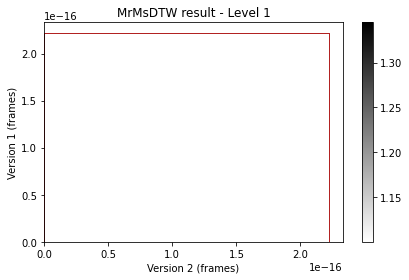

Level 0 computation time: 0.00 seconds


/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/imp/lib/python3.9/site-packages/synctoolbox/dtw/visualization.py:149: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.imshow(cur_cost, cmap='gray_r', aspect='auto', origin='lower',
/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/imp/lib/python3.9/site-packages/synctoolbox/dtw/visualization.py:149: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.imshow(cur_cost, cmap='gray_r', aspect='auto', origin='lower',


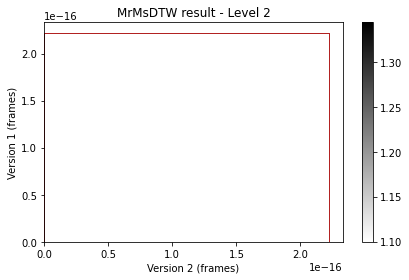

Level 1 computation time: 0.00 seconds


/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/imp/lib/python3.9/site-packages/synctoolbox/dtw/visualization.py:149: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.imshow(cur_cost, cmap='gray_r', aspect='auto', origin='lower',
/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/imp/lib/python3.9/site-packages/synctoolbox/dtw/visualization.py:149: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.imshow(cur_cost, cmap='gray_r', aspect='auto', origin='lower',


IndexError: index 1 is out of bounds for axis 0 with size 1

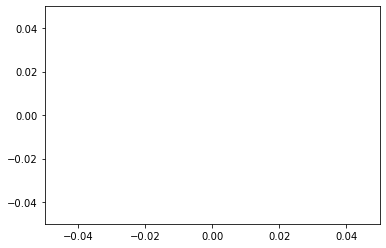

In [6]:
from synctoolbox.dtw.mrmsdtw import sync_via_mrmsdtw

wp = sync_via_mrmsdtw(f_chroma1=ref_chroma_stft[:, :8],
                    f_chroma2=chroma_first_stft,
                    input_feature_rate=feature_rate,
                    verbose=True)

* Recording in progress....
0st frame has arrived: 1647329607.307997
get 0st frame 1647329607.311448
after computating 0st frame: 1647329607.312788

1st frame has arrived: 1647329607.3933818
get 1st frame 1647329607.399095
after computating 1st frame: 1647329607.39948

2st frame has arrived: 1647329607.478722
get 2st frame 1647329607.4849532
after computating 2st frame: 1647329607.485661

3st frame has arrived: 1647329607.5642529
get 3st frame 1647329607.5713658
after computating 3st frame: 1647329607.572191

4st frame has arrived: 1647329607.649397
get 4st frame 1647329607.657259
after computating 4st frame: 1647329607.6577542

5st frame has arrived: 1647329607.734709
get 5st frame 1647329607.7399921
after computating 5st frame: 1647329607.740492

6st frame has arrived: 1647329607.820056
get 6st frame 1647329607.8263931
after computating 6st frame: 1647329607.827418

7st frame has arrived: 1647329607.905501
get 7st frame 1647329607.911631
after computating 7st frame: 1647329607.912349

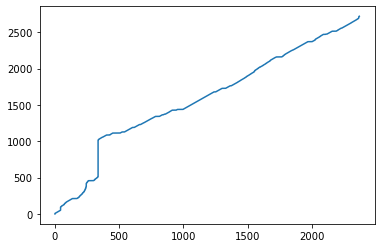

In [5]:
# librosa test

RECORD_SECONDS = 30
CHUNK_SIZE = 2048

chunks = np.array([])
query_chroma_stft = np.array([])

ref_audio, ref_sr = librosa.load("../resources/audio/target/Happy_Birthday_To_You_C_Major.wav")
ref_chroma_stft = librosa.feature.chroma_stft(y=ref_audio, sr=ref_sr, hop_length=HOP_LENGTH, n_fft=N_FFT)
cost_matrix = None
step_index_matrix = None
warping_path = None
last_pointer = None

sp = StreamProcessor(SAMPLE_RATE, CHUNK_SIZE)
sp.run()

start = time.time()
for _ in range(int(SAMPLE_RATE / CHUNK_SIZE * RECORD_SECONDS)):
    qsize = sp.chroma_buffer.qsize()
    if qsize <= 1:
        chroma_stft = sp.chroma_buffer.get()
    else:
        print(f"qsize: {qsize}")
        chroma_stfts = [sp.chroma_buffer.get() for _ in range(qsize)]  # (12, 8) * qsize
        chroma_stft = np.hstack(chroma_stfts)
    
    query_chroma_stft = np.concatenate((query_chroma_stft, chroma_stft), axis=1) if query_chroma_stft.any() else chroma_stft
    query_pointer = query_chroma_stft.shape[1]
    index = int(query_pointer / 8) - 1
    print(f"get {index}st frame {time.time()}")

    D, wp = librosa.sequence.dtw(
        X=ref_chroma_stft[:, :query_pointer],
        Y=query_chroma_stft,
        global_constraints=True,
        # subseq=True,
    )
    cost_matrix = D
    warping_path = wp
    last_pointer = query_pointer

    print(f"after computating {index}st frame: {time.time()}\n")


end = time.time()
sp.stop()
duration = end - start
print(f"duration: {duration}")

plt.plot(warping_path[:, 0], warping_path[:, 1])
plt.show()

In [6]:
last_pointer, warping_path

(2720,
 array([[2369, 2719],
        [2368, 2718],
        [2368, 2717],
        ...,
        [   0,    2],
        [   0,    1],
        [   0,    0]]))